# Classification in NLP

One of the most common tasks in NLP is to classify text into different categories. The most common example is sentiment classification where given a piece of text we try to classify into different categories of sentiment. 

However, computers dont understand natural language or text! So the first step is to convert the text into a form the computer understands. This involves a series of steps which include: 

1. Preprocessing: It involves converting text into a series of relevant tokens.
2. Feature Extraction: The set of relevant tokens is converted into features.

After this, we follow a typical supervised ML workflow i.e use the feature matrix and corresponding labels to train a classification model via: 

1. Weight Initialization
2. Prediction
3. Loss Calculation
4. Backpropagation/ Gradient Calculation
5. Weight Update

And, ad libitum weight updates until we achieve a loss that is acceptably low according to some predetermined criterion. 

## Data Exploration

Before any task, it is important to load and explore the dataset

In [2]:
# Imports and Downloads
import nltk 
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ruchira/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [5]:
# Explore text
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
print('Number of positive tweets: ', len(all_positive_tweets))
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
print('Number of negative tweets: ', len(all_negative_tweets))
print('The type of a tweet entry is: ', type(all_negative_tweets[0]))
print(f'Sample tweet entry: {all_positive_tweets[random.randint(0,5000)]}')

Number of positive tweets:  5000
Number of negative tweets:  5000
The type of a tweet entry is:  <class 'str'>
Sample tweet entry: @B_Madhura @shabnam_903 i should tweet it :p


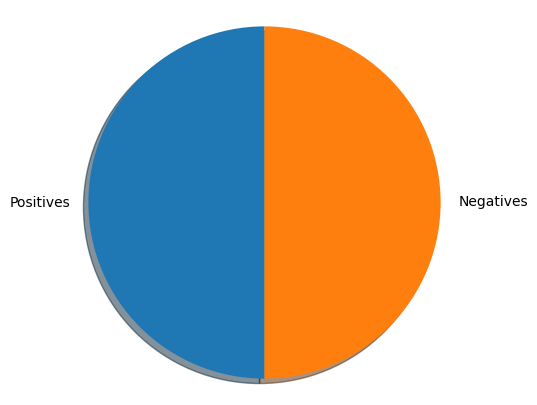

In [4]:
# Visualize data
# use pie chart with labels and sizes from our dataset
fig = plt.figure(figsize=(5, 5))
labels = ['Positives', 'Negatives']
sizes = [len(all_positive_tweets), len(all_negative_tweets)] 
plt.pie(sizes, labels=labels, 
        shadow=True, startangle=90)
plt.axis('equal')  
plt.show()

## Preprocessing

This typically involves: 

1. Tokenization
2. Lowercasing
3. Punctuation Removal
4. Stopword Removal
5. Stemming/Lemmatization

Once each text has been converted into a list of relevant tokens, we extract the corpus vocabulary.

Vocabulary: It is the list of unique tokens present in the entire set of texts. 

In [7]:
# Imports and downloads
from nltk.tokenize import TweetTokenizer 
import string 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english') 
from nltk.stem import PorterStemmer  

In [18]:
# Preprocessing Function

def preprocess_tweet(text)-> list: 
    ''' It takes tweet string as input and preprocesses it by tokenization, punctuation removal, stopword removal, and stemming
    The output is a list of tokens'''
    
    # tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokenized= tokenizer.tokenize(text)
    # lowercasing
    lowered=[word.lower() for word in tokenized]
    # punctuation and stopword removal
    cleaned=[word for word in lowered if (word not in stopwords_english and word not in string.punctuation) ]
    # stemming
    stemmer = PorterStemmer() 
    stemmed=[stemmer.stem(word) for word in cleaned]

    return stemmed

preprocess_tweet(all_negative_tweets[2])

['heart', 'slide', 'wast', 'basket', ':(']

In [27]:
# Vocabulary Extraction
# prepping corpus
tweets= all_positive_tweets + all_negative_tweets
print(type(tweets))
print(len(tweets))
print(type(tweets[0]))
print(tweets[0])

# preprocess corpus
processed_tweets= [preprocess_tweet(tweet) for tweet in tweets]
print(processed_tweets[0])

# vocabulary
vocabulary=[]
for tweet in processed_tweets:
    for token in tweet:
        if token not in vocabulary:
            vocabulary.append(token)
print(vocabulary[:50])
print(len(vocabulary))

<class 'list'>
10000
<class 'str'>
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)', 'hey', 'jame', 'odd', ':/', 'pleas', 'call', 'contact', 'centr', '02392441234', 'abl', 'assist', 'mani', 'thank', 'listen', 'last', 'night', 'bleed', 'amaz', 'track', 'scotland', 'congrat', 'yeaaah', 'yipppi', 'accnt', 'verifi', 'rqst', 'succeed', 'got', 'blue', 'tick', 'mark', 'fb', 'profil', '15', 'day', 'one', 'irresist', '#flipkartfashionfriday', 'http://t.co/ebz0l2venm', 'like', 'keep', 'love', 'custom']
12407


## Feature Extraction

Since models cannot read text, we need to convert the text into a feature vector.  This can be done in two ways: 

### One Hot Encoding

Each text is converted into a feature vector of length of the vocabulary. Each entry in the vector indicates whether a word in the vocab is present in the text.
   
### Frequency Encoding

Each text is converted into feature vector of length 3 where each value is: 

1. Bias of the model
2. Positive Frequency: For each word in text, sum over the number of times that word occurs in positive tweets
3. Negative Frequency: For each word in text, sum over the number of times that word occurs in negative tweets

The first step is to create a frequency dictionary where each word $w$ has two entries:  $(w,1)$ (number of times the word is in a positive tweet) and $(w,0)$ (number of times the word is in a negative tweet). 

In [31]:
# Imports and downloads
import numpy as np

In [32]:
# Load preprocessed tweets
print(processed_tweets[0])

# Get label list with 1/0 for all tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))
print(labels[0])

['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
1.0


In [37]:
# Building word frequency dictionary 

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # looping over all tweets and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [38]:
# create frequency dictionary
freqs = build_freqs(processed_tweets, labels)

# check data type
print(f'type(freqs) = {type(freqs)}')

# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'dict'>
len(freqs) = 15063


In [39]:
print(freqs)

{('#followfriday', 1.0): 25, ('top', 1.0): 32, ('engag', 1.0): 7, ('member', 1.0): 16, ('commun', 1.0): 32, ('week', 1.0): 83, (':)', 1.0): 3691, ('hey', 1.0): 77, ('jame', 1.0): 7, ('odd', 1.0): 2, (':/', 1.0): 5, ('pleas', 1.0): 99, ('call', 1.0): 37, ('contact', 1.0): 7, ('centr', 1.0): 2, ('02392441234', 1.0): 1, ('abl', 1.0): 8, ('assist', 1.0): 1, ('mani', 1.0): 33, ('thank', 1.0): 643, ('listen', 1.0): 17, ('last', 1.0): 47, ('night', 1.0): 68, ('bleed', 1.0): 2, ('amaz', 1.0): 51, ('track', 1.0): 5, ('scotland', 1.0): 2, ('congrat', 1.0): 21, ('yeaaah', 1.0): 1, ('yipppi', 1.0): 1, ('accnt', 1.0): 2, ('verifi', 1.0): 2, ('rqst', 1.0): 1, ('succeed', 1.0): 1, ('got', 1.0): 68, ('blue', 1.0): 9, ('tick', 1.0): 1, ('mark', 1.0): 1, ('fb', 1.0): 5, ('profil', 1.0): 2, ('15', 1.0): 4, ('day', 1.0): 245, ('one', 1.0): 131, ('irresist', 1.0): 2, ('#flipkartfashionfriday', 1.0): 17, ('http://t.co/ebz0l2venm', 1.0): 1, ('like', 1.0): 232, ('keep', 1.0): 68, ('love', 1.0): 398, ('custom'

## Logistic Regression

The next step is to build a logistic regression using the extracted features